<a href="https://colab.research.google.com/github/KatrineME/DTU_DeepLearning/blob/main/DL_Project9_U_Net_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net Algorithm
Pixelwise segmentation for medical images - Cellari






# Import & setup

In [ ]:
#Mount google drive for dataloading
import os

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Deep')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Packages

In [ ]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
from torch.autograd import Variable
import matplotlib.pyplot as plt
import glob
import os
import PIL
import cv2
from skimage import color
from skimage import io
import torch
import re

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
from skimage.measure import label
from PIL import Image
from torch import Tensor

#import sys
#sys.path.append(os.path.join('.', '..')) # Allow us to import shared custom 
#                                         # libraries, like utils.py

# Data load

In [ ]:
image_paths = glob.glob("/content/drive/My Drive/Deep/Warwick/*.bmp") # if your path to the 
print("Total Observations:\t", len(image_paths))

# now loading the train set
train_anno = np.sort(glob.glob("/content/drive/My Drive/Deep/Warwick/train_*[0-9]_anno.bmp"))
train_img  = np.sort(glob.glob("/content/drive/My Drive/Deep/Warwick/train_*[0-9].bmp"))
print("Total Observations_img:\t", len(train_img))
print("Total Observations_anno:\t", len(train_anno))

# now loading the test set
test_anno = np.sort(glob.glob("/content/drive/My Drive/Deep/Warwick/test*_*[0-9]_anno.bmp"))
test_img  = np.sort(glob.glob("/content/drive/My Drive/Deep/Warwick/test*_*[0-9].bmp"))
print("Total Observations_img:\t", len(test_img))
print("Total Observations_anno:\t", len(test_anno))


Total Observations:	 330
Total Observations_img:	 85
Total Observations_anno:	 85
Total Observations_img:	 80
Total Observations_anno:	 80


#Ordering of data


In [ ]:
# Training
train_a_list = [0]*len(train_anno)
train_i_list = [0]*len(train_img)

for i in range(0,len(train_anno)):
  a = int(re.findall(r'[0-9]+',train_anno[i])[0])
  train_a_list[i] = a

  m = int(re.findall(r'[0-9]+',train_img[i])[0])
  train_i_list[i] = m  

print("Train anno: ",train_a_list)
print("Train image: ",train_i_list)

# Test
test_a_list = [0]*len(test_anno)
test_i_list = [0]*len(test_img)

for i in range(0,len(test_anno)):
  if i > 59:  
    a = int(re.findall(r'[0-9]+',test_anno[i])[0])
    test_a_list[i] = a+60

    m = int(re.findall(r'[0-9]+',test_img[i])[0])
    test_i_list[i] = m+60

  else:
    a = int(re.findall(r'[0-9]+',test_anno[i])[0])
    test_a_list[i] = a

    m = int(re.findall(r'[0-9]+',test_img[i])[0])
    test_i_list[i] = m

#print("Test anno: ",test_a_list)
#print("Test image: ",test_i_list)


Train anno:  [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 2, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 3, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 4, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 5, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 6, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 7, 80, 81, 82, 83, 84, 85, 8, 9]
Train image:  [1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 6, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 7, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 8, 80, 81, 82, 83, 84, 85, 9]


In [ ]:
img_train_order  = [0]*len(train_img)
anno_train_order = [0]*len(train_anno)

for i in range(0,len(train_i_list)):
    for j in range(0,len(train_a_list)):
        if train_i_list[i] == train_a_list[j]:
           #print('i=',i,'j=',j)
           img_train_order[i]  =  train_img[i]
           anno_train_order[i] =  train_anno[j]
        else:
          1+1 # just something
    #print(img_train_order[i])
    #print(anno_train_order[i])

img_test_order  = [0]*len(test_img)
anno_test_order = [0]*len(test_anno)

for i in range(0,len(test_i_list)):
    for j in range(0,len(test_a_list)):
        if test_i_list[i] == test_a_list[j]:
           #print('i=',i,'j=',j)
           img_test_order[i]  =  test_img[i]
           anno_test_order[i] =  test_anno[j]
        else:
          1+1 # just something
    #print(img_test_order[i])
    #print(anno_test_order[i])


#Overall mean and std

In [ ]:
mt   = torch.empty(len(train_img),3)
st   = torch.empty(len(train_img),3)

for i in range(0,len(train_img)):
    im = np.uint8(Image.open(train_img[i]))

    m  = np.mean(im,axis=(0,1))
    mt[i,:] = Tensor(m)

    s  = np.std(im,axis=(0,1))
    st[i,:] = Tensor(s)

overall_mean = torch.mean(mt,0)
overall_std  = torch.mean(st,0)

print('mean= ',overall_mean,'std= ',overall_std)

mean=  tensor([200.7956, 130.3507, 200.2104]) std=  tensor([40.0354, 54.4116, 29.6088])


# Batch Generator - 6 images


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range 

<Figure size 2160x2160 with 0 Axes>

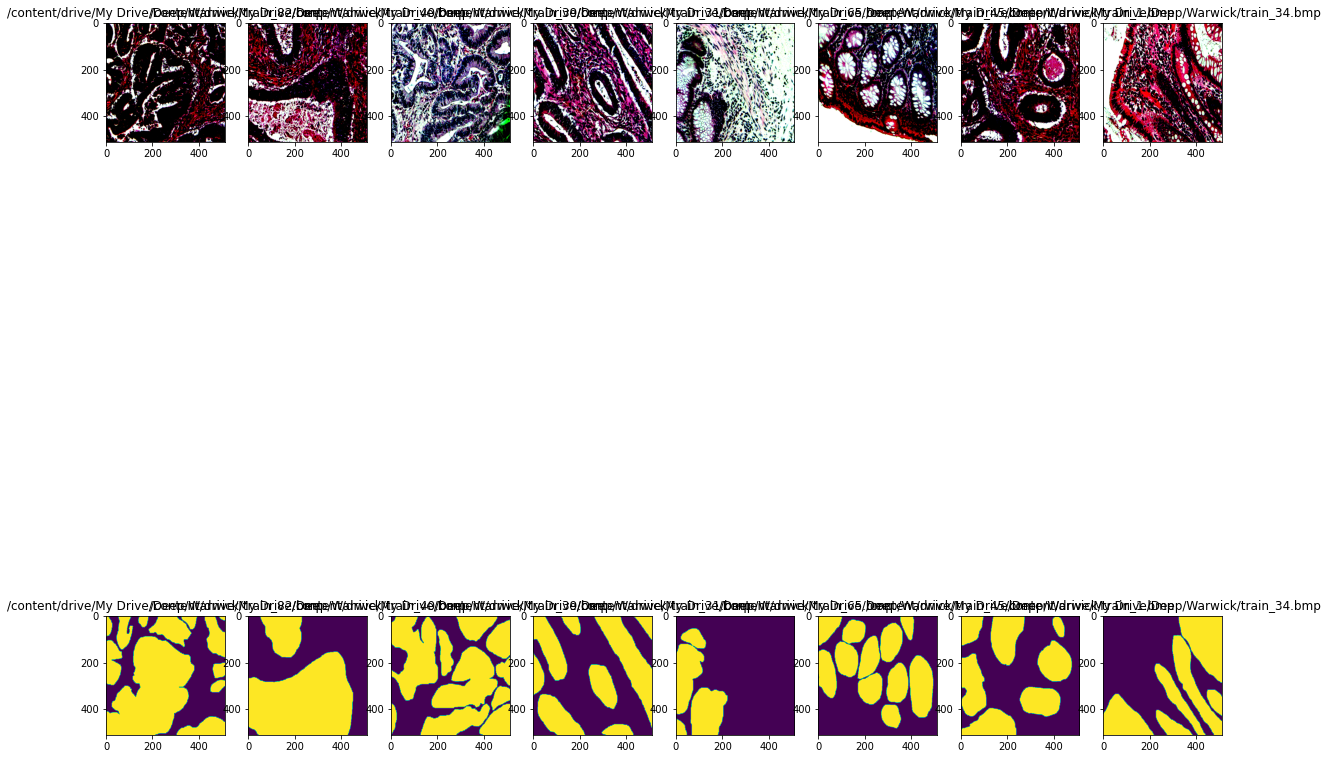

In [ ]:
# Random images: Amount of images
amount = 8
image_sample = [0]*amount #torch.empty(amount,1)
anno_sample = [0]*amount  #torch.empty(amount,1)

index = np.random.choice(list(range(0,85)), amount, replace=False)
for k,h in enumerate(index):
    image_sample[k] = img_train_order[h]
    anno_sample[k]  = anno_train_order[h]
#image_sample = np.random.choice(train_img, amount, replace = False)

plt.figure(figsize=(30,30))

imgt  = torch.empty(amount,512,512,3)
annot = torch.empty(amount,2,512,512)
imt  = torch.empty(amount,512,512,3)
mt   = torch.empty(amount,3)
st   = torch.empty(amount,3)

plt.figure(figsize=(20,20))
# NORMALIZATION OF DATA
for i in range(0,amount):
    im  = Tensor(np.uint8(Image.open(image_sample[i])))
    img = (im-overall_mean)/overall_std
    imt = resize(img, output_shape=(512,512))
    imgt[i,:,:,:]= Tensor(imt)

    anno = np.uint8(Image.open(anno_sample[i]))
    anno = resize(anno, output_shape=(512,512))
    (_, anno) = cv2.threshold(anno, 0, 1, cv2.THRESH_BINARY)
    anno = Tensor(anno)
    anno = torch.nn.functional.one_hot(anno.to(torch.int64), num_classes=-1)
    anno = anno.permute(2,0,1).float()
    annot[i,:,:,:] = Tensor(anno)

    plt.subplot(2,amount, i+1)
    plt.imshow(imgt[i,:,:,:])
    plt.title(image_sample[i])

    plt.subplot(2,amount, i+amount+1)
    plt.imshow(annot[i,1,:,:])
    plt.title(image_sample[i])

#U-Net architecture

In [ ]:
from torch.nn import Linear, LSTM, Conv2d, ConvTranspose2d, Dropout, MaxPool2d, BatchNorm1d, BatchNorm2d, CrossEntropyLoss
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
import torch.nn as nn
import torch

height, width, channels = [512, 512, 3]

filters       = 64
kernel_size1  = 3
kernel_size2  = 3

conv_stride1  = 1
conv_stride2  = 2

conv_pad1     = 1
conv_pad2     = 1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Encoder (Contracting path)
        self.conv_1 = Conv2d(in_channels = channels,
                             out_channels = filters,
                             kernel_size = kernel_size1,
                             stride = conv_stride1,
                             padding = conv_pad1)

        self.conv_2 = Conv2d(in_channels = filters,
                             out_channels = filters*2,
                             kernel_size = kernel_size1,
                             stride = conv_stride1,
                             padding = conv_pad1)
        
        self.conv_3 = Conv2d(in_channels = filters*2,
                             out_channels = filters*4,
                             kernel_size = kernel_size1,
                             stride = conv_stride1,
                             padding = conv_pad1)
        
        self.conv_4 = Conv2d(in_channels = filters*4,
                             out_channels = filters*8,
                             kernel_size = kernel_size1,
                             stride = conv_stride1,
                             padding = conv_pad1)
        
        # Middle 
        self.conv_m = Conv2d(in_channels = filters*8,
                             out_channels = filters*16,
                             kernel_size = kernel_size1,
                             stride = conv_stride1,
                             padding = conv_pad1)
        

        # Decoder (Expansive path) - Transpose 
        self.conv_trans_4 = ConvTranspose2d(in_channels = filters*16,
                             out_channels = filters*8,
                             kernel_size = kernel_size2,
                             stride = conv_stride2,
                             padding = conv_pad2,
                             output_padding=1)
        
        self.conv_de_4 = Conv2d(in_channels = filters*16,
                             out_channels = filters*8,
                             kernel_size = kernel_size2,
                             stride = conv_stride1,
                             padding = conv_pad2)
         
        self.conv_trans_3 = ConvTranspose2d(in_channels = filters*8,
                             out_channels = filters*4,
                             kernel_size = kernel_size2,
                             stride = conv_stride2,
                             padding = conv_pad2, 
                             output_padding=1)
        
        self.conv_de_3 = Conv2d(in_channels = filters*8,
                             out_channels = filters*4,
                             kernel_size = kernel_size2,
                             stride = conv_stride1,
                             padding = conv_pad2)
        
        self.conv_trans_2 = ConvTranspose2d(in_channels = filters*4,
                             out_channels = filters*2,
                             kernel_size = kernel_size2,
                             stride = conv_stride2,
                             padding = conv_pad2, 
                             output_padding=1)
        
        self.conv_de_2 = Conv2d(in_channels = filters*4,
                             out_channels = filters*2,
                             kernel_size = kernel_size2,
                             stride = conv_stride1,
                             padding = conv_pad2)
        
        self.conv_trans_1 = ConvTranspose2d(in_channels = filters*2,
                             out_channels = filters*1,
                             kernel_size = kernel_size2,
                             stride = conv_stride2,
                             padding = conv_pad2, 
                             output_padding=1)
        
        self.conv_de_1 = Conv2d(in_channels = filters*2,
                             out_channels = filters*1,
                             kernel_size = kernel_size2,
                             stride = conv_stride1,
                             padding = conv_pad2)
        
        # Output layer 
        self.conv_out = Conv2d(in_channels = filters*1,
                             out_channels = 2,
                             kernel_size = 1,
                             stride = 1,
                             padding = 0)
         
        # Max pooling
        self.maxp = MaxPool2d(kernel_size = 2, stride = 2)

    def forward(self, x_img):
        #print("Initial image:", x_img.shape)
        
        ## Contracting Convolutional layer ##
        x_img_1 = self.conv_1(x_img)
        x_img_1 = relu(x_img_1)
        max_x_img_1 = self.maxp(x_img_1)
        #print("x 1", x_img_1.shape)
        #print("After 1", max_x_img_1.shape)

        x_img_2 = self.conv_2(max_x_img_1)
        x_img_2 = relu(x_img_2)
        max_x_img_2 = self.maxp(x_img_2)
        #print("x 2", x_img_2.shape)
        #print("After 2", max_x_img_2.shape)

        x_img_3 = self.conv_3(max_x_img_2)
        x_img_3 = relu(x_img_3)
        max_x_img_3 = self.maxp(x_img_3)
        #print("x 3", x_img_3.shape)
        #print("After 3", max_x_img_3.shape)

        x_img_4 = self.conv_4(max_x_img_3)
        x_img_4 = relu(x_img_4)
        max_x_img_4 = self.maxp(x_img_4)
        #print("x 4", x_img_4.shape)
        #print("After 4", max_x_img_4.shape)

        ## Middle layer ## 
        x_img_m = self.conv_m(max_x_img_4)
        x_img_m = relu(x_img_m)
        #print("X middle:", x_img_m.shape)
        
        ## Expansive Convolutional layer ##
        x_img_t4 = self.conv_trans_4(x_img_m)
        x_img_t4 = torch.cat((x_img_t4, x_img_4), dim=1)
        x_img_t4 = self.conv_de_4(x_img_t4)
        x_img_t4 = relu(x_img_t4)
        #print("Final 4", x_img_t4.shape)
  
        x_img_t3 = self.conv_trans_3(x_img_t4)
        x_img_t3 = torch.cat((x_img_t3, x_img_3),dim=1)
        x_img_t3 = self.conv_de_3(x_img_t3)
        x_img_t3 = relu(x_img_t3)
        #print("Final 3:", x_img_t3.shape)

        x_img_t2 = self.conv_trans_2(x_img_t3)
        x_img_t2 = torch.cat((x_img_t2, x_img_2),dim=1)
        x_img_t2 = self.conv_de_2(x_img_t2)
        x_img_t2 = relu(x_img_t2)
        #print("Final 2:", x_img_t2.shape)

        x_img_t1 = self.conv_trans_1(x_img_t2)
        x_img_t1 = torch.cat((x_img_t1, x_img_1),dim=1)
        x_img_t1 = self.conv_de_1(x_img_t1)
        x_img_t1 = relu(x_img_t1)
        #print("Final 1:", x_img_t1.shape)

        x_img_out = self.conv_out(x_img_t1)
        #x_img_out = softmax(x_img_out)
        x_img_out = sigmoid(x_img_out)
        #print("Train samples ximgtout:", x_img_out.shape)

        return x_img_out

net = Net()
#print(net)
 

# Training parameters



In [ ]:
import torch.optim as optim

LEARNING_RATE = 0.001 
#criterion    = nn.CrossEntropyLoss() 
criterion     = nn.BCELoss()

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)


#Training loop

In [ ]:
num_epoch = 30 
trainloader = imgt.permute(0, 3, 1, 2)
losses = []

for epoch in range(num_epoch):  # loop over the dataset multiple times

    print('Epoch =', epoch)
    running_loss = 0.0  

    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs = trainloader
        labels = annot

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(inputs)

        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss

        losses.append(running_loss)
        #if i % 1000 == 999:    # print every 1000 mini-batches
        #print('[%d, %5d] loss: %.3f' %
        (epoch + 1, i + 1, running_loss)
        running_loss = 0.0

epochs = np.arange(len(losses))
plt.figure()
plt.plot(epochs, losses, 'r', label='Training loss ',)

print('Finished Training')

#Normalize function

In [ ]:
def Normal(image, annotation):
    im  = Tensor(np.uint8(Image.open(image)))
    img = (im-overall_mean)/overall_std
    imt = resize(img, output_shape=(512,512))
    imt = np.expand_dims(imt,axis=0)
    image_n = Tensor(imt)

    anno = np.uint8(Image.open(annotation))
    anno = resize(anno, output_shape=(512,512))
    (_, anno) = cv2.threshold(anno, 0, 1, cv2.THRESH_BINARY)
    anno = Tensor(anno)
    anno = torch.nn.functional.one_hot(anno.to(torch.int64), num_classes=-1)
    anno = anno.permute(2,0,1).float()
    anno_n = anno

    return image_n, anno_n

In [ ]:
t =65

image_n, anno_n = Normal(img_train_order[t],anno_train_order[t])
print(image_n.shape)
print(anno_n.shape)
print(index)
print(img_train_order[t])

torch.Size([1, 512, 512, 3])
torch.Size([2, 512, 512])
[80 34 32 24 61 39  0 27]
/content/drive/My Drive/Deep/Warwick/train_69.bmp


#Test network

In [ ]:
ny  = Tensor(image_n)
img = ny.permute(0, 3, 1, 2)

new = net(img)
new = new.permute(0, 2, 3, 1)
new = np.squeeze(new.detach().numpy())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of cells network processed image:  15
Number of cells annotation:  24


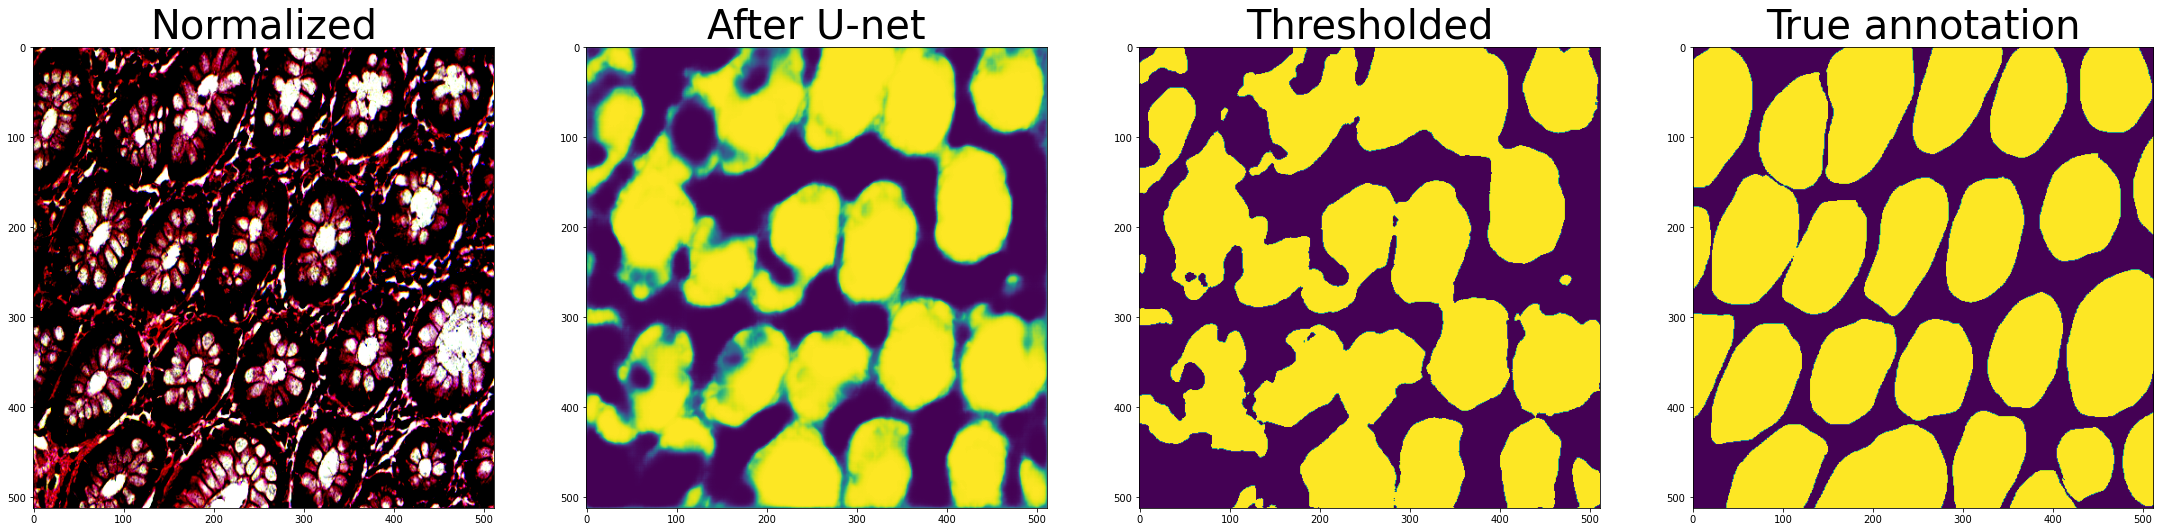

In [ ]:
plt.figure(figsize=(38,38))

plt.subplot(1,4,1)
im = np.squeeze(image_n)
plt.imshow(im)
plt.title('Normalized',fontsize=40)

plt.subplot(1,4,2)
plt.imshow(new[:,:,1])
plt.title('After U-net',fontsize=40)

(_, atest) = cv2.threshold(new, 0.5, 1, cv2.THRESH_BINARY_INV)

plt.subplot(1,4,3)
plt.imshow(atest[:,:,0])
plt.title('Thresholded',fontsize=40)

plt.subplot(1,4,4)
plt.imshow(anno_n[1,:,:])
plt.title('True annotation',fontsize=40)


(_ , n_cells) = label(atest[:,:,0], background=0, return_num=True, connectivity=1)
print('Number of cells network processed image: ',n_cells)

(_ , n_cells) = label(anno_n[1,:,:], background=0, return_num=True, connectivity=1)
print('Number of cells annotation: ',n_cells)


# OBSOBSOBS background is dim=0 and cells is dim=1

# Metrics

In [ ]:
%%shell

#We need scikit-image >0.18, this is currently not released as a pip package
# To install it, do the following
git clone https://github.com/scikit-image/scikit-image.git
cd scikit-image
pip install -e .

fatal: destination path 'scikit-image' already exists and is not an empty directory.
Obtaining file:///content/drive/My%20Drive/Deep/scikit-image
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2
  Running setup.py develop for scikit-image


In [ ]:
os.chdir('/content/drive/My Drive/Deep/scikit-image/skimage')
#! ls
import numpy as np
from skimage.measure import label
os.chdir('/content/drive/My Drive/Deep/scikit-image/skimage/metrics')
! ls
from set_metrics import hausdorff_distance

_adapted_rand_error.py	__pycache__	   _structural_similarity.py
_contingency_table.py	set_metrics.py	   tests
__init__.py		simple_metrics.py  _variation_of_information.py


In [ ]:
class BinaryImageMetrics():
    def __init__(self, y_true, y_pred):
        #TODO: Add documentation
        #TODO: implement Adjusted Rand Index and https://web.stanford.edu/class/cs273/scribing/2004/class8/scribe8.pdf
        
        # Numpy have the bug : ValueError: cannot set WRITEABLE flag to True of this array
        # That is why we copy the array

        # We force the predictions to be binary

        y_true = np.copy(y_true)
        y_pred = np.copy(y_pred)
        y_true[y_true>0]=1
        y_pred[y_pred>0] = 1
        self.y_true= y_true
        self.y_pred = y_pred
        self.y_true_label = label(self.y_true)
        self.y_pred_label = label(self.y_pred)

    def get_count(self):
        count_y_true = np.max(self.y_true_label)
        count_y_pred = np.max(self.y_pred_label)
        if count_y_pred == 0 or count_y_true == 0:
            return 0.0
        else:
            return min(count_y_true/count_y_pred, count_y_pred/count_y_true)

    def get_f1(self, y_true=None, y_pred=None):
        if y_true is None:
            y_true = self.y_true
        if y_pred is None:
            y_pred = self.y_pred
            
        if y_true.max() == 0 and y_pred.max()==0:
            return 0.0 
            
        tp, fp, _, fn = self.confusion_matrix(y_true, y_pred)
        f1 = 2*tp / (2*tp +fp + fn)
        return f1
        
    def get_iou(self, y_true=None, y_pred=None):
        if y_true is None:
            y_true = self.y_true
        if y_pred is None:
            y_pred = self.y_pred
            
        if y_true.max() == 0 and y_pred.max()==0:
            return 0.0 
            
        tp, fp, _, fn = self.confusion_matrix(y_true, y_pred)
        f1 = tp / (tp +fp + fn)
        return f1

    def get_hausdroff_dist(self, y_true=None, y_pred=None):
        if y_true is None:
            y_true = self.y_true
        if y_pred is None:
            y_pred = self.y_pred
        
        if y_true.max() == 0 or y_pred.max() == 0:
            haus_dist = np.sqrt(y_true.shape[0]*y_true.shape[1])
        else:
            haus_dist = hausdorff_distance(y_true, y_pred)
        return haus_dist

    def get_iou_obj(self):
        iou_obj = 0
        total_y_pred = max(np.bincount(self.y_pred.flatten(),minlength=2)[1],1)
        total_y_true = max(np.bincount(self.y_true.flatten(), minlength=2)[1],1)

        for idx in range(1, self.y_true_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=False)
            iou = (np.bincount(gi.flatten(), minlength=2)[1]/total_y_true)*self.get_iou(y_true=gi, y_pred=si)
            iou_obj += iou

        for idx in range(1, self.y_pred_label.max()+1):
            si, gi = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=True)
            iou = (np.bincount(si.flatten(), minlength=2)[1]/total_y_pred)*self.get_iou(y_true=si, y_pred=gi)
            iou_obj += iou

        iou_obj /= 2

        return iou_obj


    def get_f1_obj(self):
        f1_obj = 0
        total_y_pred = max(np.bincount(self.y_pred.flatten(),minlength=2)[1],1)
        total_y_true = max(np.bincount(self.y_true.flatten(), minlength=2)[1],1)

        for idx in range(1, self.y_true_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=False)
            f1 = (np.bincount(gi.flatten(), minlength=2)[1]/total_y_true)*self.get_f1(y_true=gi, y_pred=si)
            f1_obj += f1

        for idx in range(1, self.y_pred_label.max()+1):
            si, gi = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=True)
            f1 = (np.bincount(si.flatten(), minlength=2)[1]/total_y_pred)*self.get_f1(y_true=si, y_pred=gi)
            f1_obj += f1

        f1_obj /= 2

        return f1_obj


    def get_hausdorff_obj_distance(self):
        haus_dist_obj = 0
        total_y_pred = np.bincount(self.y_pred.flatten(), minlength=2)[1]
        total_y_true = np.bincount(self.y_true.flatten(), minlength=2)[1]
        
        if total_y_true == 0 or total_y_pred == 0:
            # Note this conversion is different from
            # https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/evaluation/
            # But the Hausdorff distance is not defined for non-overlapping objects.
            # Note that the distance of sqrt(h^2+w^2) is an arbary choice.
            # 0.0 would skew the distance to much to the positive side, and
            # infinite is misleading. 
            # In case both objects are empty, we return the max dist of y_true
            return np.sqrt(self.y_true.shape[0]**2+self.y_true.shape[1]**2)

        for idx in range(1, self.y_true_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=True, y_true_p_switch=False)
            if gi.max() == 0 or si.max() == 0:
                haus_dist = ((gi.shape[0]*gi.shape[1])/total_y_true)*np.sqrt(gi.shape[0]**2+gi.shape[1]**2)
            else:
                haus_dist = (np.bincount(gi.flatten())[1]/total_y_true)*self.get_hausdroff_dist(y_true=gi, y_pred=si)
            haus_dist_obj += haus_dist

        for idx in range(1, self.y_pred_label.max()+1):
            si, gi = self._get_overlap(idx, return_rectangle=True, y_true_p_switch=True)
            if gi.max() == 0 or si.max() == 0:
                haus_dist = ((si.shape[0]*si.shape[1])/total_y_pred)*np.sqrt(si.shape[0]**2+si.shape[1]**2)
            else:
                haus_dist = (np.bincount(si.flatten())[1]/total_y_pred)*self.get_hausdroff_dist(y_true=si, y_pred=gi)
            haus_dist_obj += haus_dist

        haus_dist_obj /= 2
        return haus_dist_obj

    def confusion_matrix(self, y_true, y_pred):
        y_true= y_true.flatten()
        y_pred = y_pred.flatten()*2
        cm = y_true+y_pred
        cm = np.bincount(cm, minlength=4)
        tn, fp, fn, tp = cm
        return tp, fp, tn, fn
    
    def _get_overlap(self, idx, return_rectangle=False, y_true_p_switch=False):
        if y_true_p_switch:
            y_pred = self.y_true_label
            y_true = self.y_pred_label
        else:
            y_true = self.y_true_label
            y_pred = self.y_pred_label

        roi_y_true = np.argwhere(y_true == idx)
        roi_y_pred = y_pred[roi_y_true[:,0],roi_y_true[:,1]]

        # Finds max overlap, excluding background
        matching_idx = np.bincount(roi_y_pred)
        if len(matching_idx)<=1:
            matching_idx = -1
        else:
            matching_idx = matching_idx[1:].argmax()+1
        if return_rectangle:
            bbox, _, _ = self._bounding_box(roi_y_true, at_origon=False)
            roi_y_true = y_true[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]
            roi_y_pred = y_pred[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]
            roi_y_true =(roi_y_true==idx)*1

        else:
            roi_y_true = np.ones((len(roi_y_true)),dtype=int)
        roi_y_pred = (roi_y_pred==matching_idx)*1
        
        return roi_y_true, roi_y_pred
        
    def _bounding_box(self, points, at_origon=False):
        bbox = [min(points[:,0]), min(points[:,1]), max(points[:,0]), max(points[:,1])]
        min_x = bbox[0]
        min_y = bbox[1]
        if at_origon:
            bbox = [bbox[0] - min_x,
                    bbox[1] - min_y,
                    bbox[2] - min_x,
                    bbox[3] - min_y]
        return bbox, min_x, min_y
        

#Test of function w. metrics

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


<class 'torch.Tensor'>
<class 'numpy.ndarray'>
F1-object 0.7202717171829511
Hausdorff 175.37817681435587
iou 0.621019653458171
count 0.23076923076923078
f1 0.8672046025515522
<bound method BinaryImageMetrics.get_iou_obj of <__main__.BinaryImageMetrics object at 0x7f093d48deb8>>


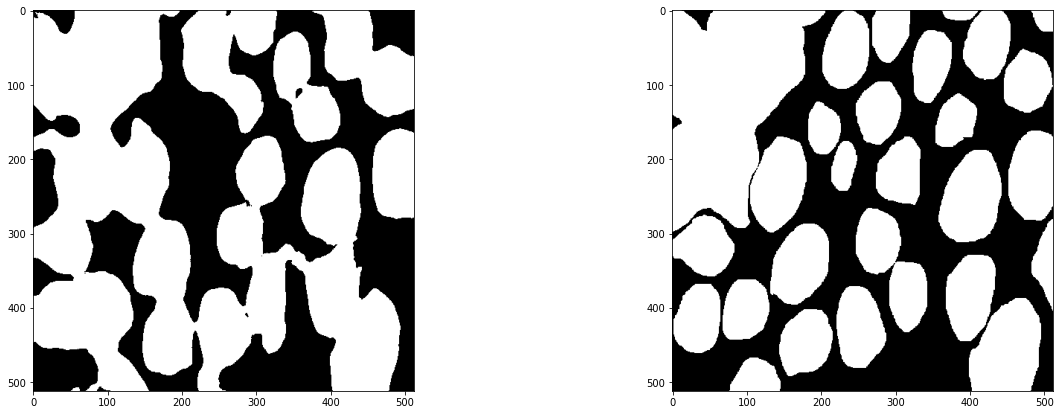

In [ ]:
plt.figure(figsize=(21,7))

i=20
(image, true) = Normal(img_test_order[i], anno_test_order[i])
    
img = image.permute(0, 3, 1, 2)
new = net(img)
new = new.permute(0, 2, 3, 1)
new = np.squeeze(new.detach().numpy())

(_, pred) = cv2.threshold(new, 0.5, 1, cv2.THRESH_BINARY_INV)
pred = np.uint8(pred[:,:,0])
true = np.uint8(true[1,:,:])

metrics = BinaryImageMetrics(true, pred)

plt.subplot(121)
plt.imshow(pred, cmap='gray')

plt.subplot(122)
plt.imshow(true, cmap='gray')

print(type(image))
print(type(pred))

print('F1-object',metrics.get_f1_obj())
print('Hausdorff',metrics.get_hausdorff_obj_distance())
print('iou',metrics.get_iou_obj())
print('count',metrics.get_count())
print('f1',metrics.get_f1())
print(metrics.get_iou_obj)

In [ ]:
t = 5

m = np.zeros((6,t))
import random 

for i in range(0,t):

    n = random.randint(0,80)

    (image, true) = Normal(img_test_order[n], anno_test_order[n])
    print(img_test_order[n])
    print(anno_test_order[n])
    
    img = image.permute(0, 3, 1, 2)
    new = net(img)
    new = new.permute(0, 2, 3, 1)
    new = np.squeeze(new.detach().numpy())

    (_, pred) = cv2.threshold(new, 0.5, 1, cv2.THRESH_BINARY)
    pred = np.uint8(pred[:,:,0])
    true = np.uint8(true[1,:,:])

    metrics = BinaryImageMetrics(true, pred)

    m[0,i] = metrics.get_f1_obj()
    m[1,i] = metrics.get_hausdorff_obj_distance()
    m[2,i] = metrics.get_iou_obj()
    m[3,i] = metrics.get_count()
    m[4,i] = metrics.get_f1()



/content/drive/My Drive/Deep/Warwick/testA_35.bmp
/content/drive/My Drive/Deep/Warwick/testA_35_anno.bmp


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/content/drive/My Drive/Deep/Warwick/testA_27.bmp
/content/drive/My Drive/Deep/Warwick/testA_27_anno.bmp
/content/drive/My Drive/Deep/Warwick/testB_18.bmp
/content/drive/My Drive/Deep/Warwick/testB_18_anno.bmp
/content/drive/My Drive/Deep/Warwick/testA_11.bmp
/content/drive/My Drive/Deep/Warwick/testA_11_anno.bmp
/content/drive/My Drive/Deep/Warwick/testB_9.bmp
/content/drive/My Drive/Deep/Warwick/testB_9_anno.bmp


In [ ]:
print('F1 object "Dice":  min:',m[0,:].min(),' median:',np.median(m[0,:]),'   mean:',np.mean(m[0,:]),' max:',m[0,:].max())
print('Hausdorff "shape": min:',m[1,:].min(),'   median:',np.median(m[1,:]),'  mean:',np.mean(m[1,:]),' max:',m[1,:].max())
print('IoU:               min:',m[2,:].min(),' median:',np.median(m[2,:]),'mean:',np.mean(m[2,:]),' max:',m[2,:].max())
print('Count:             min:',m[3,:].min(),'median:',np.median(m[3,:]),'mean:',np.mean(m[3,:]),'max:',m[3,:].max())
print('F1:                min:',m[4,:].min(),' median:',np.median(m[4,:]),' mean:',np.mean(m[4,:]),'max:',m[4,:].max())


F1 object "Dice":  min: 0.16781014804299593  median: 0.22422984732908313    mean: 0.26558496421185274  max: 0.5256195033086453
Hausdorff "shape": min: 192.79269712622542    median: 293.31991365875655   mean: 269.40097320143207  max: 329.42207619678805
IoU:               min: 0.1153326641008448  median: 0.13621405542672915 mean: 0.2082384700629322  max: 0.49634745660506424
Count:             min: 0.03333333333333333 median: 0.4117647058823529 mean: 0.378763197586727 max: 0.6153846153846154
F1:                min: 0.08691714353080311  median: 0.16073842953718148  mean: 0.25770112109626575 max: 0.6980917691227111
